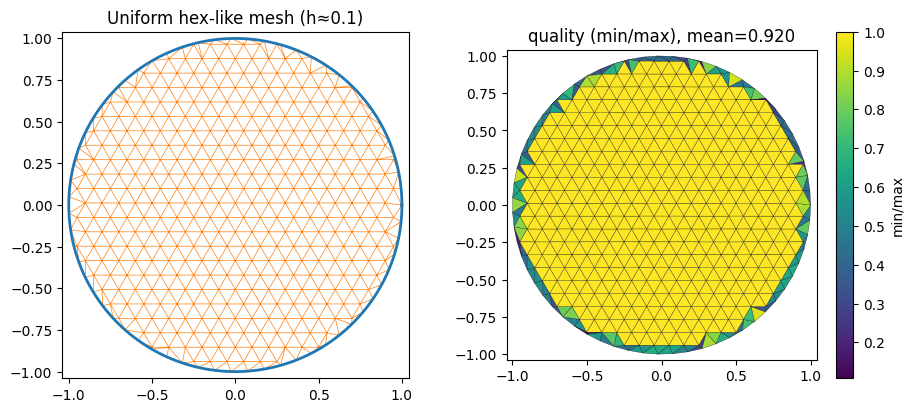

In [15]:
"""
Uniform hex-like lattice clipped by a circle:
- build regular triangular lattice (step h)
- keep interior points + add boundary points on circumference
- Delaunay (SciPy)
- Quality metric: min(edge) / max(edge)
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy.spatial import Delaunay

# ---------- lattice + helpers ----------
def triangular_lattice_points(h=0.12, bbox=(-1,1,-1,1)) -> np.ndarray:
    xmin, xmax, ymin, ymax = bbox
    dy = np.sqrt(3)/2 * h
    ys = np.arange(ymin, ymax + dy, dy)
    pts = []
    for k, y in enumerate(ys):
        xshift = (h/2 if (k % 2 == 1) else 0.0)
        xs = np.arange(xmin - h, xmax + h, h) + xshift
        for x in xs:
            pts.append([x, y])
    return np.asarray(pts)

def boundary_points(n_boundary, radius=1.0, center=(0.0,0.0)) -> np.ndarray:
    cx, cy = center
    ang = np.linspace(0, 2*np.pi, n_boundary, endpoint=False)
    xb = cx + radius*np.cos(ang)
    yb = cy + radius*np.sin(ang)
    return np.column_stack([xb, yb])

def mask_outside_by_centroid(points: np.ndarray, simplices: np.ndarray, center, radius) -> np.ndarray:
    cx, cy = center
    tri_pts = points[simplices]
    centroids = tri_pts.mean(axis=1)
    d2 = (centroids[:,0]-cx)**2 + (centroids[:,1]-cy)**2
    return d2 > radius**2 * (1 + 1e-6)

# ---------- QUALITY: min/max edge ----------
def triangle_quality_minmax(points: np.ndarray, simplices: np.ndarray) -> np.ndarray:
    a = points[simplices[:,0]]
    b = points[simplices[:,1]]
    c = points[simplices[:,2]]
    e1 = np.linalg.norm(b - a, axis=1)
    e2 = np.linalg.norm(c - b, axis=1)
    e3 = np.linalg.norm(a - c, axis=1)
    lengths = np.stack([e1, e2, e3], axis=1)
    return lengths.min(axis=1) / (lengths.max(axis=1) + 1e-12)

# ---------- pipeline ----------
def build_uniform_circle_mesh(R=1.0, center=(0.0,0.0), h=0.14, n_boundary=None):
    cx, cy = center
    bbox = (cx-R-2*h, cx+R+2*h, cy-R-2*h, cy+R+2*h)
    lattice = triangular_lattice_points(h, bbox)

    d2 = (lattice[:,0]-cx)**2 + (lattice[:,1]-cy)**2
    interior = lattice[d2 < (R-1e-9)**2]

    if n_boundary is None:
        n_boundary = max(12, int(np.round(2*np.pi*R / h)))
    bnd = boundary_points(n_boundary, R, center)

    points = np.vstack([interior, bnd])

    tri = Delaunay(points)
    simplices = tri.simplices
    mask = mask_outside_by_centroid(points, simplices, center, R)
    tris_in = simplices[~mask]
    return points, tris_in

# ---------- demo ----------
if __name__ == "__main__":
    R = 1.0
    CENTER = (0.0, 0.0)
    H = 0.1

    pts, tris = build_uniform_circle_mesh(R, CENTER, H, n_boundary=None)
    q = triangle_quality_minmax(pts, tris)
    mean_q = float(np.mean(q))

    tri_obj = mtri.Triangulation(pts[:,0], pts[:,1], triangles=tris)
    fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

    ax = axes[0]
    ax.set_title(f"Uniform hex-like mesh (h≈{H})")
    t = np.linspace(0, 2*np.pi, 400)
    ax.plot(CENTER[0] + R*np.cos(t), CENTER[1] + R*np.sin(t), linewidth=2)
    ax.triplot(tri_obj, linewidth=0.5)
    ax.set_aspect('equal', adjustable='box')

    ax = axes[1]
    tpc = ax.tripcolor(tri_obj, facecolors=q, edgecolors='k', linewidth=0.2)
    ax.set_title(f"quality (min/max), mean={mean_q:.3f}")
    ax.set_aspect('equal', adjustable='box')
    fig.colorbar(tpc, ax=ax, label="min/max")

    for ax in axes: ax.margins(0.02)
    plt.savefig('1.png')
    plt.show()



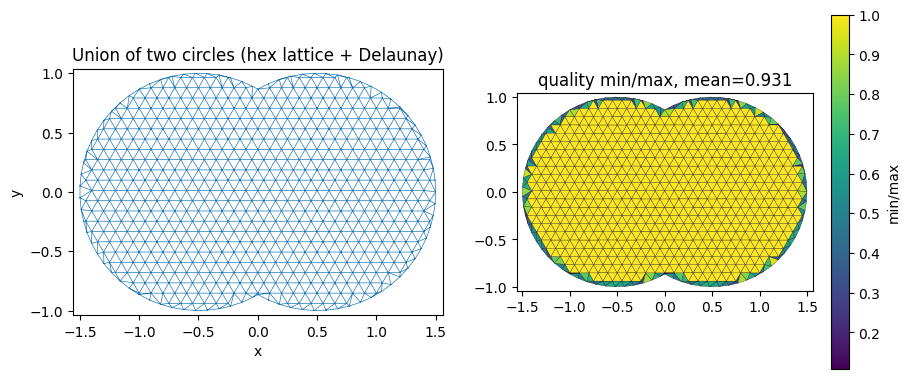

In [16]:
"""
Triangulation of the UNION of two circles with a uniform hex-like lattice.
- Interior: regular triangular (hex) lattice clipped to union of circles
- Boundary: sample points only on EXPOSED arcs of each circle (no inner seam)
- Triangulation: SciPy Delaunay
- Quality metric: min(edge_length) / max(edge_length)  in [0,1]
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy.spatial import Delaunay
from math import pi

# ---------- LATTICE ----------
def triangular_lattice_points(h: float, bbox: tuple[float,float,float,float]) -> np.ndarray:
    """Triangular (hex) lattice covering bbox=(xmin,xmax,ymin,ymax) with step ~ h."""
    xmin, xmax, ymin, ymax = bbox
    dy = np.sqrt(3.0) / 2.0 * h
    ys = np.arange(ymin, ymax + dy, dy)
    pts = []
    for k, y in enumerate(ys):
        xshift = (h / 2.0) if (k % 2 == 1) else 0.0
        xs = np.arange(xmin - h, xmax + h, h) + xshift
        for x in xs:
            pts.append([x, y])
    return np.asarray(pts, dtype=float)

# ---------- GEOMETRY HELPERS ----------
def inside_union_circles(xy: np.ndarray, circles: list[tuple[float,float,float]]) -> np.ndarray:
    """Mask of points that lie inside the UNION of given circles."""
    mask = np.zeros(len(xy), dtype=bool)
    for cx, cy, R in circles:
        d2 = (xy[:, 0] - cx) ** 2 + (xy[:, 1] - cy) ** 2
        mask |= d2 <= R ** 2 + 1e-12
    return mask

def centroid_keep_mask(points: np.ndarray, tris: np.ndarray,
                       circles: list[tuple[float,float,float]]) -> np.ndarray:
    """Keep triangles whose centroids lie inside the union."""
    centroids = points[tris].mean(axis=1)
    return inside_union_circles(centroids, circles)

def n_for_chord(R: float, h: float, min_n: int = 12) -> int:
    """Choose boundary sample count n so that chord length 2R*sin(pi/n) ≈ h."""
    n0 = max(min_n, int(round(2.0 * pi * R / h)))
    best_n, best_err = n0, float("inf")
    for n in range(max(min_n, n0 - 6), n0 + 7):
        err = abs(2.0 * R * np.sin(pi / n) - h)
        if err < best_err:
            best_n, best_err = n, err
    return best_n

def boundary_points_exposed_arcs(circles: list[tuple[float,float,float]], h: float) -> np.ndarray:
    """
    Boundary samples ONLY on exposed arcs of each circle:
    discard points that would fall inside any other circle (prevents inner seam).
    """
    chunks = []
    for i, (cx, cy, R) in enumerate(circles):
        n = n_for_chord(R, h)
        ang = np.linspace(0.0, 2.0 * pi, n, endpoint=False)
        cand = np.column_stack([cx + R * np.cos(ang), cy + R * np.sin(ang)])
        keep = np.ones(n, dtype=bool)
        for j, (cx2, cy2, R2) in enumerate(circles):
            if j == i:
                continue
            d2 = (cand[:, 0] - cx2) ** 2 + (cand[:, 1] - cy2) ** 2
            keep &= d2 >= (R2 ** 2 - 1e-12)  # strictly outside other circles
        chunks.append(cand[keep])
    if not chunks:
        return np.empty((0, 2), dtype=float)
    bnd = np.vstack(chunks)
    # Deduplicate very close points (touching arcs)
    grid = (bnd / (h * 0.25)).round().astype(int)
    _, idx = np.unique(grid, axis=0, return_index=True)
    return bnd[np.sort(idx)]

# ---------- QUALITY ----------
def triangle_quality_minmax(points: np.ndarray, simplices: np.ndarray) -> np.ndarray:
    """q = min(edge) / max(edge) ∈ [0,1]; 1 for equilateral."""
    a = points[simplices[:, 0]]
    b = points[simplices[:, 1]]
    c = points[simplices[:, 2]]
    e1 = np.linalg.norm(b - a, axis=1)
    e2 = np.linalg.norm(c - b, axis=1)
    e3 = np.linalg.norm(a - c, axis=1)
    L = np.stack([e1, e2, e3], axis=1)
    return L.min(axis=1) / (L.max(axis=1) + 1e-12)

# ---------- PIPELINE ----------
def build_union_two_circles_mesh(c1: tuple[float,float,float],
                                 c2: tuple[float,float,float],
                                 h: float = 0.10,
                                 bbox_margin: float = 2.0):
    """
    c1, c2: (cx, cy, R)
    h: target edge length
    """
    circles = [c1, c2]

    xs, ys, Rs = zip(*circles)
    xmin = min(cx - R for cx, R in zip(xs, Rs)) - bbox_margin * h
    xmax = max(cx + R for cx, R in zip(xs, Rs)) + bbox_margin * h
    ymin = min(cy - R for cy, R in zip(ys, Rs)) - bbox_margin * h
    ymax = max(cy + R for cy, R in zip(ys, Rs)) + bbox_margin * h

    lattice = triangular_lattice_points(h, (xmin, xmax, ymin, ymax))
    interior = lattice[inside_union_circles(lattice, circles)]
    boundary = boundary_points_exposed_arcs(circles, h)

    points = np.vstack([interior, boundary]) if len(boundary) else interior
    tri = Delaunay(points)
    T = tri.simplices
    T = T[centroid_keep_mask(points, T, circles)]
    return points, T

# ---------- MAIN ----------
if __name__ == "__main__":
    # Two unit circles centered at (-0.5, 0) and (0.5, 0)
    C1 = (-0.5, 0.0, 1.0)
    C2 = ( 0.5, 0.0, 1.0)
    H  = 0.10  # target edge length

    pts, tris = build_union_two_circles_mesh(C1, C2, h=H)

    # Quality
    q = triangle_quality_minmax(pts, tris)
    mean_q = float(np.mean(q))

    # Plot: mesh + quality map
    tri_obj = mtri.Triangulation(pts[:, 0], pts[:, 1], triangles=tris)
    fig, axes = plt.subplots(1, 2, figsize=(10.5, 4.6))

    ax = axes[0]
    ax.triplot(tri_obj, linewidth=0.5)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("Union of two circles (hex lattice + Delaunay)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.margins(0.02)

    ax = axes[1]
    tpc = ax.tripcolor(tri_obj, facecolors=q, edgecolors='k', linewidth=0.2)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f"quality min/max, mean={mean_q:.3f}")
    fig.colorbar(tpc, ax=ax, label="min/max")
    ax.margins(0.02)

    plt.savefig('2.png')
    plt.show()
